In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))
from griddedoutput_plotting import *
from loaddatastructs import *

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
GriddedOutput.archive_path = '/data/keeling/a/sf20/e/wrf-partmc-gridded-output'
GriddedOutput.gridsize = 100

GriddedOutput.addScenario(scenario_name='uniform-basecase', slurm_id=4599545)
GriddedOutput.addScenario(scenario_name='point-source-1x1', slurm_id=4599634)

In [3]:
# NOTE: USER SELECT SCENARIO
#scenario = 'uniform-basecase'
scenario = 'point-source-1x1'

z_idx = 40 # 0 indexing
t_idx = 37 # 1 indexing

# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)

Loading file


In [122]:
GriddedOutput.scenario_slurm_map.keys()

dict_keys(['uniform-basecase', 'point-source-1x1'])

In [120]:
np.arange(0, 100, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [123]:
# NOTE: USER SELECT SCENARIO
#scenario = 'uniform-basecase'
scenario = 'point-source-1x1'

z_idx = 40 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

for scenario in GriddedOutput.scenario_slurm_map:
    for t_idx in np.arange(1, 38):
        for z_idx in np.arange(0, 100, 10):
            print(scenario, t_idx, z_idx)
            GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)

uniform-basecase 1 0
File does not exist, processing data
uniform-basecase 1 10
File does not exist, processing data
uniform-basecase 1 20
File does not exist, processing data
uniform-basecase 1 30
File does not exist, processing data
uniform-basecase 1 40
Loading file
uniform-basecase 1 50
File does not exist, processing data
uniform-basecase 1 60
File does not exist, processing data
uniform-basecase 1 70
File does not exist, processing data
uniform-basecase 1 80
File does not exist, processing data
uniform-basecase 1 90
File does not exist, processing data
uniform-basecase 2 0
File does not exist, processing data
uniform-basecase 2 10
File does not exist, processing data
uniform-basecase 2 20
File does not exist, processing data
uniform-basecase 2 30
File does not exist, processing data
uniform-basecase 2 40
Loading file
uniform-basecase 2 50
File does not exist, processing data
uniform-basecase 2 60
File does not exist, processing data
uniform-basecase 2 70
File does not exist, proc

Plot the mean number distribution across the vertical layer

In [5]:
crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=GriddedOutput.gridded_data[scenario]['aero_diams'],
                                                          particle_numconc_arr=GriddedOutput.gridded_data[scenario]['aero_numconc'],
                                                          n_grid_cells=GriddedOutput.gridded_data[scenario]['n_total_cells'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


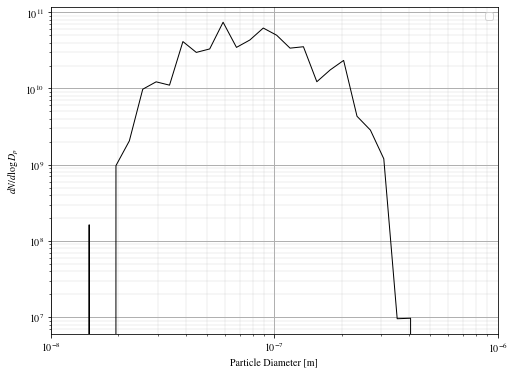

In [6]:
plotNumberDist(crosssec_mean_num_dist_optimized, plot_type='line',
                xlims=(1e-8, 1e-6) 
               #ylims=(1e6, 1e11)
               )

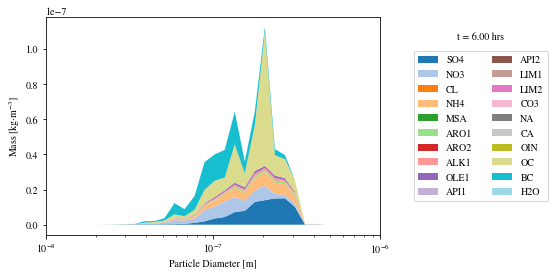

In [5]:
crosssec_binned_mean_species_mass_optimized =  getBinnedSpeciesMassOptimized(GriddedOutput.gridded_data[scenario]['aero_diams'],
                                                                             GriddedOutput.gridded_data[scenario]['aero_masses'], 
                                                                             GriddedOutput.gridded_data[scenario]['aero_numconc'], 
                                                                             n_grid_cells=GriddedOutput.gridded_data[scenario]['n_total_cells'])

plotSpeciatedMassDist(crosssec_binned_mean_species_mass_optimized, yscale='linear', xlims=(1e-8, 1e-6),
                      scenario=scenario, t_idx=t_idx, z_idx=z_idx, savefig=True
                      )

/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/May-2024-final-runs/../../griddedoutput_plotting.py:90: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin


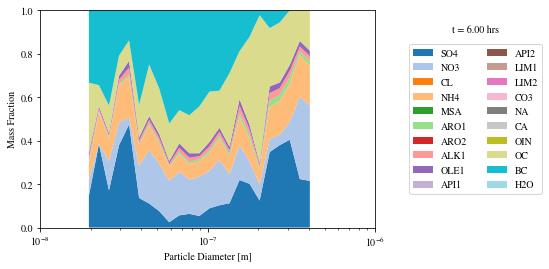

In [9]:
plotSpeciatedMassFrac(crosssec_binned_mean_species_mass_optimized, xlims=(1e-8, 1e-6), 
                      scenario=scenario, t_idx=t_idx, z_idx=z_idx, savefig=True
                      )

Plot the number distribution for each hour on the same figure (requires loading in NetCDF datasets)

Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file


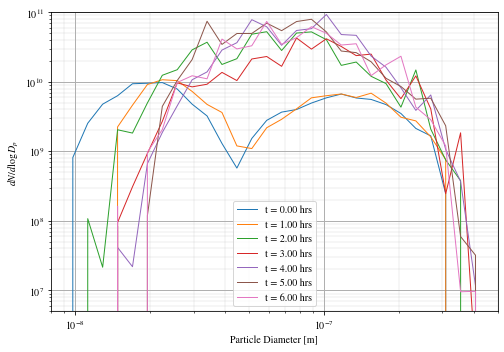

In [5]:
#scenario = 'uniform-basecase'
scenario = 'point-source-1x1'

z_idx = 1 # 0 indexing
t_idx = 37 # 1 indexing

# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

colors = plt.get_cmap('tab10')(np.linspace(0, 1, 10))
fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
times = np.arange(1, GriddedOutput.n_times+1,6)

for t, c in zip(times, colors):

    GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t)
    
    crosssec_mean_num_dist_optimized = getNumberDistOptimized(particle_diam_arr=GriddedOutput.gridded_data[scenario]['aero_diams'],
                                                              particle_numconc_arr=GriddedOutput.gridded_data[scenario]['aero_numconc'],
                                                              n_grid_cells=GriddedOutput.gridded_data[scenario]['n_total_cells'])

    
    ax = plotNumberDist(crosssec_mean_num_dist_optimized, plot_type='line', ax=ax, color=c, t_idx=t,
                        #yscale='linear'
                        #ylims=(1e6, 1e11)
                        xlims=(8e-9, 5e-7), ylims=(5e6, 1e11)
                        )


Make speciated mass distribution and mass fraction plots for the basecase

In [ ]:
scenario = 'uniform-basecase'
#scenario = 'point-source-1x1'

z_idx = 40 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

#colors = plt.get_cmap('tab10')(np.linspace(0, 1, 10))
#fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))
time_interval = 1
times = np.arange(1, GriddedOutput.n_times+1, time_interval)
for t in times:
    GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t)
    crosssec_binned_mean_species_mass_optimized =  getBinnedSpeciesMassOptimized(GriddedOutput.gridded_data[scenario]['aero_diams'],
                                                                                 GriddedOutput.gridded_data[scenario]['aero_masses'], 
                                                                                 GriddedOutput.gridded_data[scenario]['aero_numconc'], 
                                                                                 n_grid_cells=GriddedOutput.gridded_data[scenario]['n_total_cells'])

    plotSpeciatedMassDist(crosssec_binned_mean_species_mass_optimized, yscale='linear', 
                      xlims=(1e-8, 4e-6), scenario=scenario, t_idx=t, z_idx=z_idx, savefig=False
                      )
    #plt.close()
    plotSpeciatedMassFrac(crosssec_binned_mean_species_mass_optimized, xlims=(1e-8, 7e-7), 
                        scenario=scenario, t_idx=t, z_idx=z_idx, savefig=False
                      )
    #plt.close()

Loading file
Loading file
Loading file
Loading file


/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/May-2024-final-runs/../../griddedoutput_plotting.py:168: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin


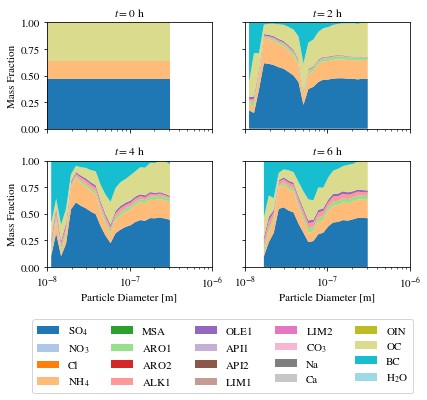

In [4]:
scenario = 'uniform-basecase'

z_idx = 40 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

time_interval = 12 # output is 10 mins, so 2 hr between each subplot
times = np.arange(1, GriddedOutput.n_times+1, time_interval)
plotFourPanelMassFrac(scenario, times, xstart, xend, ystart, yend, z_idx, yscale='linear', 
                      xlims=(1e-8, 1e-6),savefig=True)

Loading file
Loading file


/data/nriemer/b/sf20/wrf-partmc-spatial-het/WRFV3/test/em_les/analysis/gridded_output/May-2024-final-runs/../../griddedoutput_plotting.py:168: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin


Loading file
Loading file


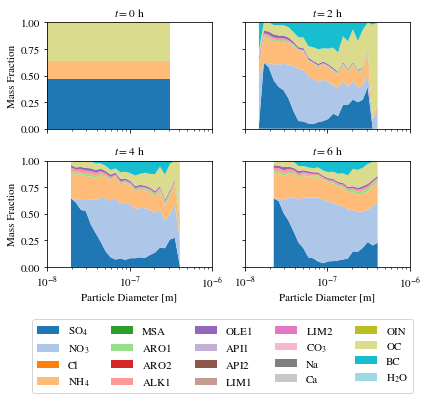

In [6]:
scenario = 'point-source-1x1'

z_idx = 40 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

time_interval = 12 # output is 10 mins, so 2 hr between each subplot
times = np.arange(1, GriddedOutput.n_times+1, time_interval)
plotFourPanelMassFrac(scenario, times, xstart, xend, ystart, yend, z_idx, yscale='linear', 
                      xlims=(1e-8, 1e-6),savefig=True)

Print variable names, dimensions, and descriptions

In [19]:
printGriddedOutputInfo(data)

process                      dimensions: ()           description: the process number (starting from 1) that output this data file  -  
total_processes              dimensions: ()           description: total number of processes  -  
time                         dimensions: ()           description: time elapsed since simulation start  -  
timestep                     dimensions: ()           description: current timestep size  -  
timestep_index               dimensions: ()           description: an integer that is 1 on the first timestep, 2 on the second timestep, etc.  -  
gas_species                  dimensions: (77,)        description: dummy dimension variable (no useful value) - read species names as comma-separated values from the 'names' attribute  -  
gas_mosaic_index             dimensions: (77,)        description: MOSAIC indices of gas species  -  
aero_species                 dimensions: (20,)        description: dummy dimension variable (no useful value) - read species n

In [77]:
np.arange(1, 38, 6)

array([ 1,  7, 13, 19, 25, 31, 37])

Code for 2d (kappa vs. diameter) kappa distributions

In [202]:
# NOTE: USER SELECT SCENARIO
scenarios = ['uniform-basecase', 'point-source-1x1']

#z_idx = 40 # 0 indexing
#t_idx = 18

for t_idx in np.arange(1, 38, 6): # each hour (note using 1-indexing here)
    for z_idx in np.arange(0, 91, 10): # every 10th vertical level

        # use a width of 10, horizontally average across the 10x10 grid cells
        xstart, xend = 45, 55 # 1 indexing
        ystart, yend = 45, 55 # 1 indexing

        general_labels = {'uniform-basecase': 'Uniform base case', 
                        'point-source-1x1': 'Scenario 3'}

        # plot from kappa=(0,1) and diameters=(1e-8, 1e-6), weight by the number conc. of each computation particle. 
        fig, axs = plt.subplots(1,2, figsize=(8, 4))
        plt.subplots_adjust(wspace=.15)

        for i, (ax, scenario) in enumerate(zip(axs.flatten(), scenarios)):
            GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)

            # 1-d arrays with per-particle attributes
            kappa = GriddedOutput.gridded_data[scenario]['aero_kappa']
            diams = GriddedOutput.gridded_data[scenario]['aero_diams']
            numconc = GriddedOutput.gridded_data[scenario]['aero_numconc']
            n_cells = GriddedOutput.gridded_data[scenario]['n_total_cells']

            diam_bins = np.logspace(-8, -6, 50)
            #diam_bins = GriddedOutput.bin_edges
            kappa_bins = np.linspace(0, 1, 51)
            diam_logwidth = (np.log10(diam_bins[1:]) - np.log10(diam_bins[0:-1]))[0]
            kappa_width = (kappa_bins[1:] - kappa_bins[0:-1])[0]
            hist, xedges, yedges, cs = ax.hist2d(diams, kappa, bins=[diam_bins, kappa_bins], weights=numconc/(diam_logwidth*n_cells), 
                                                density=False, cmin=1,edgecolor='face', linewidth=.1, zorder=10)
            ax.set_xscale('log')

            if i != 0:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel('$\kappa$', fontsize=12)

            ax.set_xlabel('Particle diameter (m)', fontsize=12)
            
            ax.set_title(f'{general_labels[scenario]}')
            #ax.set_title(f'{scenario}')

            ax.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,3), c='#414141', alpha=.5, zorder=0)
            ax.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white', zorder=0)
            ax.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,3), c='#414141', zorder=0)
            ax.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141', zorder=0)
            ax.tick_params(axis='both', labelsize=10, which='major', direction='in', top=True, right=True, bottom=True, left=True)
            ax.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

        cbar = fig.colorbar(cs, ax=axs, orientation='horizontal', fraction=0.05, pad=0.2)
        cbar_title = 'Number conc. (m$^{-3}$)'
        cbar.set_label(label=cbar_title, fontsize=12)
        cbar.ax.tick_params(labelsize=11)
        plt.savefig(f'2d-kappa-dist-two-panel-z{z_idx}-t{t_idx}.pdf', format='pdf', bbox_inches='tight')
        plt.close()

Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file

Code for 1-d kappa distributions, dividing the distribution into nucleation, aitken, accumulation modes

In [201]:
# NOTE: USER SELECT SCENARIO
scenarios = ['uniform-basecase', 'point-source-1x1']

z_idx = 40 # 0 indexing
#t_idx = 19

# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

general_labels = {'uniform-basecase': 'Uniform base case', 
                'point-source-1x1': 'Scenario 3'}

for t_idx in np.arange(1, 38, 6): # each hour (note using 1-indexing here)

    # plot from kappa=(0,1) and diameters=(1e-8, 1e-6), weight by the number conc. of each computation particle. 
    fig, axs = plt.subplots(1,2, figsize=(8, 4))


    fig2, axs2 = plt.subplots(2,1, figsize=(6, 4))
    plt.subplots_adjust(hspace=.25)

    mode_colors = {'nucleation_mode': '', 'aitken_mode': '', 'accum_mode': ''}
    viridis = plt.get_cmap('viridis')
    for i, mode in zip(np.linspace(0.2, .8, len(mode_colors.keys())), mode_colors):

        rgba = viridis(i)
        hex_color = mplcolors.to_hex(rgba)
        mode_colors[mode] = hex_color

    for i, (ax, ax2, scenario) in enumerate(zip(axs.flatten(), axs2.flatten(), scenarios)):
        GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)

        # 1-d arrays with per-particle attributes
        kappa = GriddedOutput.gridded_data[scenario]['aero_kappa']
        diams = GriddedOutput.gridded_data[scenario]['aero_diams']
        numconc = GriddedOutput.gridded_data[scenario]['aero_numconc']
        n_cells = GriddedOutput.gridded_data[scenario]['n_total_cells']

        diam_bins = np.logspace(-8, -6, 50)
        #diam_bins = GriddedOutput.bin_edges
        kappa_bins = np.linspace(0, 1, 51)
        diam_logwidth = (np.log10(diam_bins[1:]) - np.log10(diam_bins[0:-1]))[0]
        kappa_width = (kappa_bins[1:] - kappa_bins[0:-1])[0]
        hist, xedges, yedges, cs = ax.hist2d(diams, kappa, bins=[diam_bins, kappa_bins], weights=numconc/(diam_logwidth*n_cells), 
                                            density=False, cmin=1,edgecolor='face', linewidth=.1, zorder=10)
        plt.close(fig=fig)


        kappa_bin_centers = 0.5*(kappa_bins[0:-1] + kappa_bins[1:])
        nucleation_mode = hist[:, diam_bins<5e-8]
        aitken_mode = hist[:, (diam_bins>=5e-8)&(diam_bins<1e-7)]
        accum_mode = hist[:, (diam_bins>=1e-7)]
        ax2.plot(kappa_bin_centers[:-1], np.nansum(nucleation_mode, axis=1), label='Nucleation', c=mode_colors['nucleation_mode'])
        ax2.plot(kappa_bin_centers[:-1], np.nansum(aitken_mode, axis=1), label='Aitken', c=mode_colors['aitken_mode'])
        ax2.plot(kappa_bin_centers[:-1], np.nansum(accum_mode, axis=1), label='Accum.', c=mode_colors['accum_mode'])
        total_dist = np.nansum(nucleation_mode, axis=1) + np.nansum(aitken_mode, axis=1) + np.nansum(accum_mode, axis=1)
        ax2.plot(kappa_bin_centers[:-1], total_dist, label='Total', c='k', ls=':')


        ax2.set_title(f'{general_labels[scenario]}')

        if i ==0:
            ax2.set_xticklabels([])
            fig2.legend(fontsize=11, ncol=4, loc='center', bbox_to_anchor=(.5,-.03))
        else:
            ax2.set_xlabel('$\kappa$', fontsize=13) 
        ax2.set_ylabel('$dN/d\kappa$', fontsize=11)              
        
        ax2.set_ylim(0, ax2.get_ylim()[1])
        ax2.set_xlim(0,1)

        ax2.grid(which = "major", linewidth = 1, axis='y', ls="dotted", dashes=(.5,3), c='#414141', alpha=.5, zorder=0)
        ax2.grid(which = "minor", linewidth = 1, axis='y', ls="dotted", dashes=(.5,6), c='white', zorder=0)
        ax2.grid(which = "minor", linewidth = 1, axis='x', ls="dotted", dashes=(.5,3), c='#414141', zorder=0)
        ax2.grid(which = "major", linewidth = 1, axis='x', ls="dotted", dashes=(.5,6), c='#414141', zorder=0)
        ax2.tick_params(axis='both', labelsize=10, which='major', direction='in', top=True, right=True, bottom=True, left=True)
        ax2.tick_params(axis='both', which='minor',direction='in',top=True, right=True, bottom=True, left=True)

    plt.savefig(f'1d-kappa-dist-two-panel-z{z_idx}-t{t_idx}.pdf', format='pdf', bbox_inches='tight')
    plt.close(fig=fig2)


Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file


In [53]:
def KappaDist(scenario):
    kappa = GriddedOutput.gridded_data[scenario]['aero_kappa']
    particle_multipicity = GriddedOutput.gridded_data[scenario]['aero_numconc']

    nbins = 90
    kappa_bins = np.linspace(0, 1, nbins+1)
    kappa_width = kappa_bins[1] - kappa_bins[0]

    digitized = np.digitize(kappa, kappa_bins) 
    bin_conc = np.zeros(nbins)

    for bin_idx in np.arange(nbins):
        bin_conc[bin_idx] = (particle_multipicity[(digitized-1)==bin_idx].sum())/kappa_width
    bin_conc = bin_conc/GriddedOutput.gridded_data[scenario]['n_total_cells']

    return kappa_bins, bin_conc

Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file
Loading file


Text(0, 0.5, '$dN/d\\kappa$')

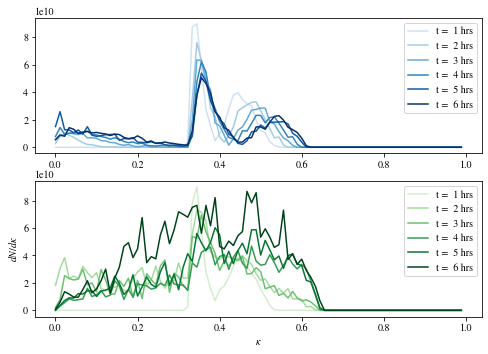

In [105]:
z_idx = 20 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing

times = np.arange(7, 38, 6)

basecase_colors = plt.get_cmap('Blues')(np.linspace(0.2, 1, times.size))
pointsource_colors = plt.get_cmap('Greens')(np.linspace(0.2, 1, times.size))

fig, ax = plt.subplots(2, 1, figsize=(8, 5.5))


for i, t_idx in enumerate(times):

    scenario = 'uniform-basecase'
    GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)
    bins, bin_conc = KappaDist(scenario)
    history_dt = GriddedOutput.historydelta_m/60 # hours
    time =  ((t_idx-1)*history_dt)
    label = f't = {time:2.0f} hrs'
    ax[0].plot(bins[:-1], bin_conc, label=label, c=basecase_colors[i])

    scenario = 'point-source-1x1'
    GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)
    bins, bin_conc = KappaDist(scenario)

    ax[1].plot(bins[:-1], bin_conc,c=pointsource_colors[i], label=label)



ax[0].legend()
ax[1].legend()
#plt.yscale('log')
#plt.ylim(0, 1.4e11)
plt.xlabel('$\kappa$')
plt.ylabel('$dN/d\kappa$')


Loading file
Loading file


Text(0.5, 1.0, 't =  6 hrs')

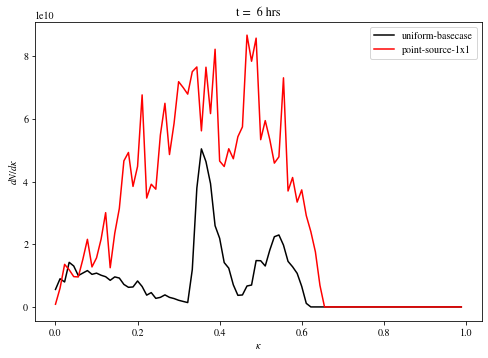

In [118]:


z_idx = 20 # 0 indexing
# use a width of 10, horizontally average across the 10x10 grid cells
xstart, xend = 45, 55 # 1 indexing
ystart, yend = 45, 55 # 1 indexing
t_idx=37

fig, ax = plt.subplots(1, 1, figsize=(8, 5.5))

scenario = 'uniform-basecase'
GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)
bins, bin_conc = KappaDist(scenario)

ax.plot(bins[:-1], bin_conc, label=scenario, c='k')

scenario = 'point-source-1x1'
GriddedOutput.loadData(scenario, xstart, xend, ystart, yend, z_idx, t_idx)
bins, bin_conc = KappaDist(scenario)

ax.plot(bins[:-1], bin_conc,c='r', label=scenario)



ax.legend()
#plt.yscale('log')
#plt.ylim(0, 1.4e11)
plt.xlabel('$\kappa$')
plt.ylabel('$dN/d\kappa$')
history_dt = GriddedOutput.historydelta_m/60 # hours
time =  ((t_idx-1)*history_dt)
label = f't = {time:2.0f} hrs'
plt.title(label)